In [1]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


📌 **Explicación de las librerías utilizadas**

🔹 pandas:

* Usada para cargar y manipular datasets en formato tabular (CSV).
* Permite crear nuevas columnas, manejar valores nulos y procesar el texto (title + abstract).

🔹 numpy

* Se utiliza para operaciones numéricas y manejo de arreglos.
* Convierte listas en arreglos eficientes que luego serán procesados por PyTorch o scikit-learn.

🔹 torch (PyTorch)
* Es esencial porque Hugging Face transformers está construido sobre PyTorch.

🔹 joblib
* Permite reutilizar el codificador de etiquetas en futuras predicciones.

🔹 json
* Se usa para guardar datos estructurados en formato JSON

🔹 sklearn.model_selection.train_test_split
* Divide el dataset en entrenamiento (train) y prueba (test).

🔹 sklearn.preprocessing.MultiLabelBinarizer
* Convierte etiquetas multiclase en formato de texto a un formato binario (One-hot encoding).

🔹 sklearn.metrics (f1_score, precision_score, recall_score, accuracy_score, hamming_loss)
* Permite calcular métricas de evaluación multilabel:

🔹transformers (Hugging Face)
* `AutoTokenizer`: convierte texto en tokens que entiende SciBERT.
* `AutoModelForSequenceClassification`: carga el modelo SciBERT con una capa final adaptada a clasificación multilabel.
* `TrainingArguments`: define hiperparámetros (epochs, batch size, learning rate, etc.).
* `Trainer`: gestiona el entrenamiento, evaluación y predicción de forma automática.

In [2]:
# ================================================
# PIPELINE DE CLASIFICACIÓN CON SCIBERT
# ================================================
import pandas as pd
import numpy as np
import torch
import joblib, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

📌 **Carga y alistamiento de Dataset**

1. Se cargan los datos (read_csv).

2. Se crea el texto de entrada (title + abstract).

3. Se convierten las etiquetas a listas (split("|")).

4. Se binarizan las etiquetas con MultiLabelBinarizer.

5. Se guarda el codificador de etiquetas (joblib y json).

6. Se divide en train/test para entrenar y evaluar correctamente.

In [3]:
  # ================================================
  # 1. Cargar dataset
  # ================================================
  df = pd.read_csv("/content/challenge_data-18-ago.csv", sep=";")

  # El dataset tiene: title, abstract, group
  # Usamos title + abstract como texto de entrada
  df["text"] = df["title"].fillna("") + " " + df["abstract"].fillna("")

  # Suponiendo que la columna de etiquetas es "labels" y contiene strings tipo "A,B"
  df["labels"] = df["group"].fillna("").astype(str).apply(lambda x: x.split("|") if x else [])


  mlb = MultiLabelBinarizer()
  y = mlb.fit_transform(df["labels"])

  joblib.dump(mlb, "./label_encoder.pkl")
  with open("label_encoder.json", "w") as f:
      json.dump(mlb.classes_.tolist(), f)

  X_train, X_test, y_train, y_test = train_test_split(df["text"], y, test_size=0.2, random_state=42)



*📌* **Tokenización mediante SciBERT**

1. Se tokenizan los textos usando SciBERT (allenai/scibert_scivocab_uncased), optimizado para lenguaje científico.

2. Se aplica truncamiento y padding (max_length=256) para que todas las secuencias tengan la misma longitud.

3. Se define una clase Dataset personalizada que: Encapsula los encodings y las etiquetas binarias. Implementa __len__ y __getitem__ para acceder a los datos como tensores de PyTorch.

4. Se crean train_dataset y test_dataset combinando encodings y etiquetas.

5. Esta preparación permite:
  * Entrenar con inputs consistentes y normalizados, mejorando la estabilidad
  * Manejar datasets multilabel correctamente.


In [4]:
# ================================================
# 2. Tokenización (SciBERT)
# ================================================
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=256)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).float()
        return item

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

📌 **Modelo SciBERT**
1. Se utiliza SciBERT, una variante de BERT entrenada en artículos científicos.

2. Este modelo entiende mejor el vocabulario biomédico y técnico del dataset.

3. La tarea se configura como clasificación multilabel, ya que un artículo puede pertenecer a varias categorías al mismo tiempo.

4. El número de etiquetas (num_labels) se ajusta automáticamente según las clases presentes en el dataset.

In [5]:
# ================================================
# 3. Modelo SciBERT para clasificación multilabel
# ================================================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📌 **Hiperparametros**

📉 Learning rate = 2e-5 → pequeño para no dañar el preentrenamiento de SciBERT y asegurar convergencia estable.

🧮 Batch size = 8 → ajustado a la memoria, mantiene estabilidad en los gradientes.

🔄 Épocas = 15 → suficientes para aprender sin caer en overfitting.

⚖️ Weight decay = 0.01 → regularización para evitar sobreajuste.

📊 Eval & Save por época → se monitorea desempeño y se guarda el mejor modelo.

🏆 load_best_model_at_end=True → asegura usar el modelo con mejor validación al final.

In [6]:
# ================================================
# 4. Configuración de entrenamiento
# ================================================
training_args = TrainingArguments(
    output_dir="./scibert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
)


📌 **Métricas**

✔️ **F1 (micro):** Evalúa el balance entre precisión y recall considerando todas las etiquetas de manera agregada.

✔️ **Precision (micro):** Porcentaje de etiquetas predichas correctamente sobre todas las predicciones positivas.

✔️ **Recall (micro):** Porcentaje de etiquetas reales que fueron correctamente identificadas por el modelo.

✔️ **F1 (weighted):** F1-score ponderado según la proporción de cada clase, útil para evaluar desempeño equilibrado en etiquetas frecuentes y raras.

✔️ **Precision (weighted):** Precisión ponderada por clase, reflejando desempeño general considerando la distribución de etiquetas.

✔️ **Recall (weighted):** Recall ponderado por clase, evaluando exhaustividad global del modelo.

✔️ **Exact match ratio:** Proporción de muestras donde todas las etiquetas fueron predichas correctamente.

✔️ **Hamming Loss:** Porcentaje de etiquetas incorrectamente clasificadas, penalizando errores parciales en multilabel.

In [7]:
# ================================================
# 5. Definir Trainer con métricas multilabel
# ================================================
def compute_metrics(pred):
    preds = (torch.sigmoid(torch.tensor(pred.predictions)) > 0.5).int().numpy()
    labels = pred.label_ids
    return {
        "f1": f1_score(labels, preds, average="micro"),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
        "precision_weighted": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall_weighted": recall_score(labels, preds, average="weighted", zero_division=0),
        "exact_match_ratio": accuracy_score(labels, preds),
        "hamming_loss": hamming_loss(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [8]:
# ================================================
# 6. Entrenar
# ================================================
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mateo-bravor (mateo-bravor-universidad-de-antioquia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,F1 Weighted,Precision Weighted,Recall Weighted,Exact Match Ratio,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,No log,0.143881,0.932760,0.960133,0.906904,0.932536,0.960031,0.906904,0.845722,0.043829,10.892900,65.455000,8.262000
2,0.234200,0.138344,0.936763,0.960440,0.914226,0.936261,0.960142,0.914226,0.856942,0.041374,10.972400,64.981000,8.202000
3,0.097200,0.129111,0.937733,0.954496,0.921548,0.937428,0.954085,0.921548,0.858345,0.041024,10.890800,65.468000,8.264000
4,0.097200,0.135501,0.945032,0.955128,0.935146,0.945038,0.955181,0.935146,0.873773,0.036466,10.953300,65.095000,8.217000
5,0.055200,0.154343,0.940260,0.933953,0.946653,0.940631,0.935071,0.946653,0.859748,0.040323,10.937900,65.186000,8.228000
6,0.031800,0.158967,0.945474,0.957128,0.934100,0.945360,0.957153,0.934100,0.872370,0.036115,10.920000,65.293000,8.242000
7,0.031800,0.178533,0.940432,0.947928,0.933054,0.940401,0.947910,0.933054,0.861150,0.039621,10.958300,65.065000,8.213000
8,0.019600,0.182230,0.943277,0.947257,0.939331,0.943556,0.948053,0.939331,0.872370,0.037868,10.917700,65.307000,8.243000
9,0.009700,0.183760,0.944269,0.949260,0.939331,0.944381,0.949515,0.939331,0.875175,0.037167,10.917600,65.308000,8.244000
10,0.006100,0.190530,0.940869,0.941361,0.940377,0.940995,0.941681,0.940377,0.863955,0.039621,10.864200,65.628000,8.284000


TrainOutput(global_step=5355, training_loss=0.04324825086068261, metrics={'train_runtime': 3252.9125, 'train_samples_per_second': 13.151, 'train_steps_per_second': 1.646, 'total_flos': 5628046536253440.0, 'train_loss': 0.04324825086068261, 'epoch': 15.0})

In [9]:
# ================================================
# 7. Evaluar modelo
# ================================================

# Evaluar modelo
results = trainer.evaluate()
print(json.dumps(results, indent=4))

# Guardar resultados en archivo JSON
with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)

{
    "eval_loss": 0.12911055982112885,
    "eval_f1": 0.9377328366152209,
    "eval_precision": 0.9544962080173348,
    "eval_recall": 0.9215481171548117,
    "eval_f1_weighted": 0.9374279009645027,
    "eval_precision_weighted": 0.9540849594043556,
    "eval_recall_weighted": 0.9215481171548117,
    "eval_exact_match_ratio": 0.8583450210378681,
    "eval_hamming_loss": 0.04102384291725105,
    "eval_runtime": 10.818,
    "eval_samples_per_second": 65.909,
    "eval_steps_per_second": 8.32,
    "epoch": 15.0
}


📌 **Matriz de confusión**

1. Se obtienen las predicciones del modelo sobre el conjunto de prueba (trainer.predict).

2. Se aplica sigmoid y umbral 0.5 para convertir logits en predicciones binarias multilabel.

3. Se calculan las matrices de confusión multilabel usando multilabel_confusion_matrix, generando una matriz independiente por cada clase.

4. Cada matriz muestra los cuatro componentes:

* TN (True Negative): aciertos en negativos.
* FP (False Positive): falsos positivos.
* FN (False Negative): falsos negativos.
* TP (True Positive): aciertos en positivos.

5. Se visualiza cada matriz con ConfusionMatrixDisplay para interpretar el desempeño del modelo por clase, identificando posibles errores de predicción o sesgos hacia ciertas etiquetas.

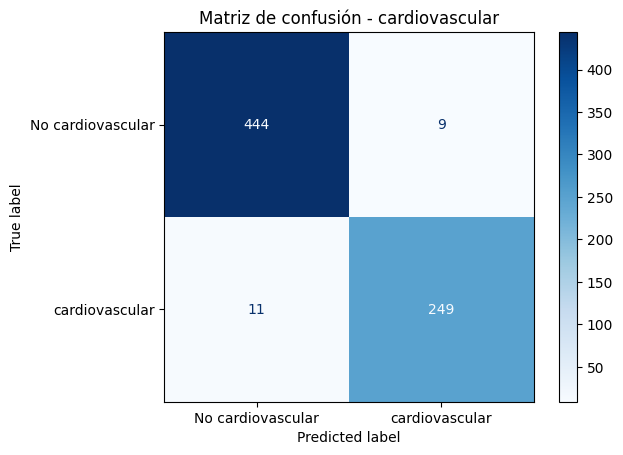

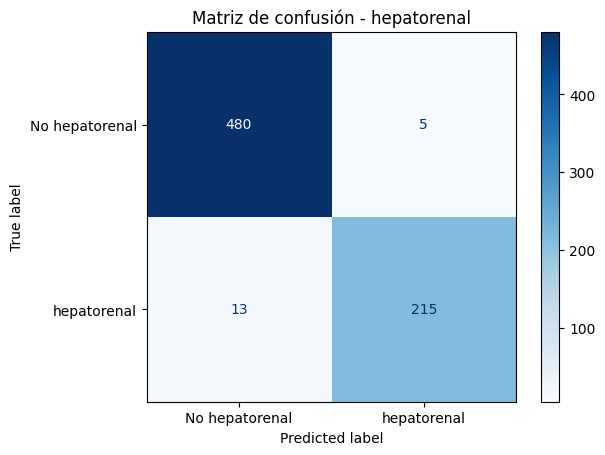

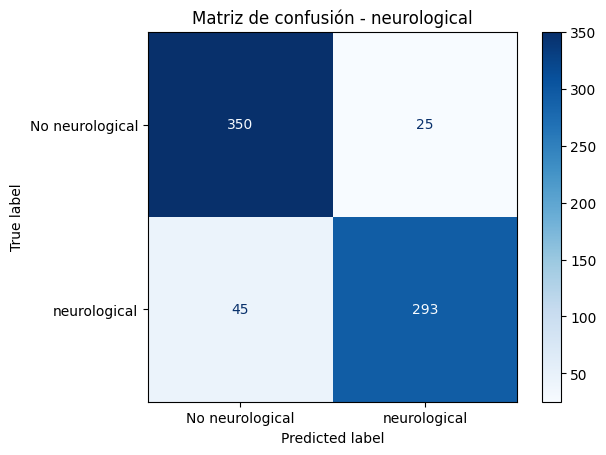

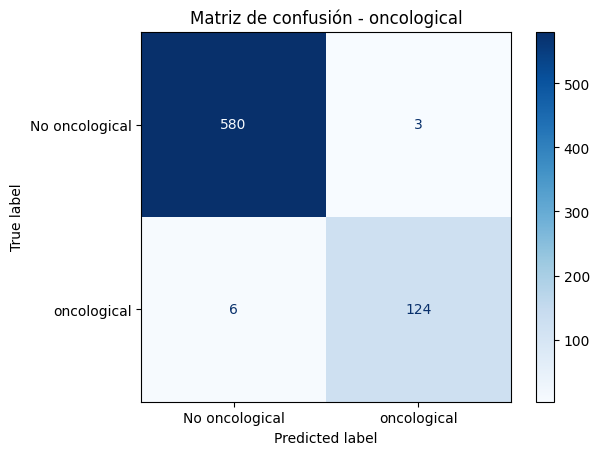

In [10]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ================================================
# 8. Matriz de confusión
# ================================================
# Obtener predicciones en el set de test
predictions = trainer.predict(test_dataset)
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
labels = predictions.label_ids

# Calcular matriz de confusión multilabel
cm = multilabel_confusion_matrix(labels, preds)

# Mostrar matriz por cada clase
for i, class_name in enumerate(mlb.classes_):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[f"No {class_name}", class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión - {class_name}")
    plt.show()


In [11]:
cm = multilabel_confusion_matrix(labels, preds)

# Crear un diccionario con cada clase y su matriz
cm_dict = {}
for i, class_name in enumerate(mlb.classes_):
    cm_dict[class_name] = {
        "TN": int(cm[i][0][0]),
        "FP": int(cm[i][0][1]),
        "FN": int(cm[i][1][0]),
        "TP": int(cm[i][1][1])
    }

# Guardar en un archivo JSON
with open("confusion_matrices.json", "w") as f:
    json.dump(cm_dict, f, indent=4)


In [12]:
# ================================================
# 9. Guardar modelo y tokenizer
# ================================================
trainer.save_model("./scibert_classifier")
tokenizer.save_pretrained("./scibert_classifier")



('./scibert_classifier/tokenizer_config.json',
 './scibert_classifier/special_tokens_map.json',
 './scibert_classifier/vocab.txt',
 './scibert_classifier/added_tokens.json',
 './scibert_classifier/tokenizer.json')

In [13]:
# ================================================
# 10. Ejemplo de predicción con un texto nuevo
# ================================================


# Texto de entrada: Es "title + abstract" como se hizo en el dataset
example_text = "Mechanisms of myocardial ischemia induced by epinephrine: comparison with exercise-induced ischemia. The role of epinephrine in eliciting myocardial ischemia was examined in patients with coronary artery disease. Objective signs of ischemia and factors increasing myocardial oxygen consumption were compared during epinephrine infusion and supine bicycle exercise. Both epinephrine and exercise produced myocardial ischemia as evidenced by ST segment depression and angina. However, the mechanisms of myocardial ischemia induced by epinephrine were significantly different from those of exercise. Exercise-induced myocardial ischemia was marked predominantly by increased heart rate and rate-pressure product with a minor contribution of end-diastolic volume, while epinephrine-induced ischemia was characterized by a marked increase in contractility and a less pronounced increase in heart rate and rate-pressure product. These findings indicate that ischemia produced by epinephrine, as may occur during states of emotional distress, has a mechanism distinct from that due to physical exertion."

def predict(text, model, tokenizer, mlb, threshold=0.5, max_length=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    predicted_labels = [cls for cls, prob in zip(mlb.classes_, probs) if prob > threshold]
    return predicted_labels, probs

labels, probs = predict(example_text, model, tokenizer, mlb)
print("Etiquetas predichas:", labels)

Etiquetas predichas: ['cardiovascular']


In [14]:
# ================================================
# 11. Descargar el modelo
# ================================================

# Comprimir la carpeta en un archivo .zip
!zip -r scibert_classifier.zip ./scibert_classifier

# 2. Descargar a tu computador
from google.colab import files
files.download("scibert_classifier.zip")


  adding: scibert_classifier/ (stored 0%)
  adding: scibert_classifier/tokenizer.json (deflated 71%)
  adding: scibert_classifier/model.safetensors (deflated 7%)
  adding: scibert_classifier/special_tokens_map.json (deflated 42%)
  adding: scibert_classifier/training_args.bin (deflated 53%)
  adding: scibert_classifier/vocab.txt (deflated 52%)
  adding: scibert_classifier/config.json (deflated 53%)
  adding: scibert_classifier/tokenizer_config.json (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>